In [1]:
%pip install scikit-rf matplotlib pymoo joblib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import skrf as rf

In [3]:
%matplotlib inline
from pylab import *
rf.stylely()

In [30]:
ant = rf.Network("tests/2450AT18A100.s1p")
line = rf.DefinedGammaZ0(frequency=ant.frequency, z0=50)

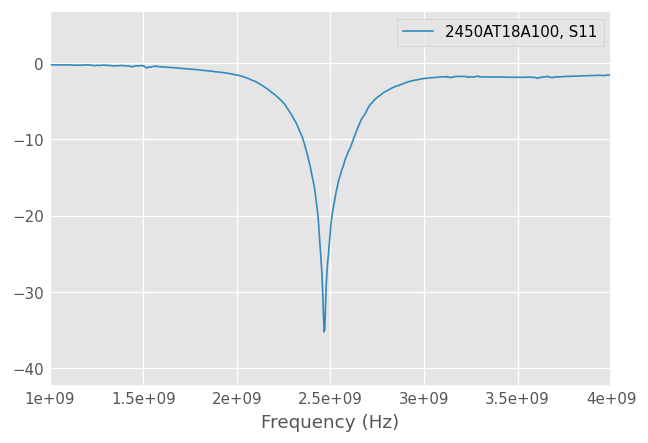

In [5]:
ant.plot_s_db()

In [6]:
ant_detune = (line.shunt_capacitor(0.5e-12)**line.inductor(0.1e-9)**line.shunt_capacitor(0.5e-12)**ant)
ant_detune.name = ant.name+'dt'

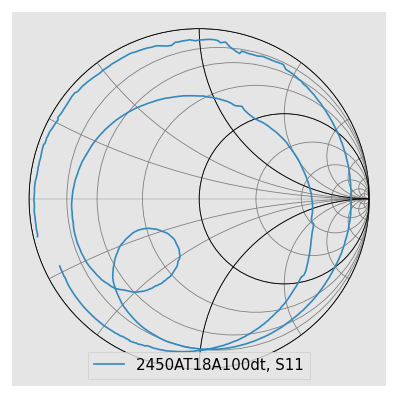

In [7]:
ant_detune.plot_s_smith()

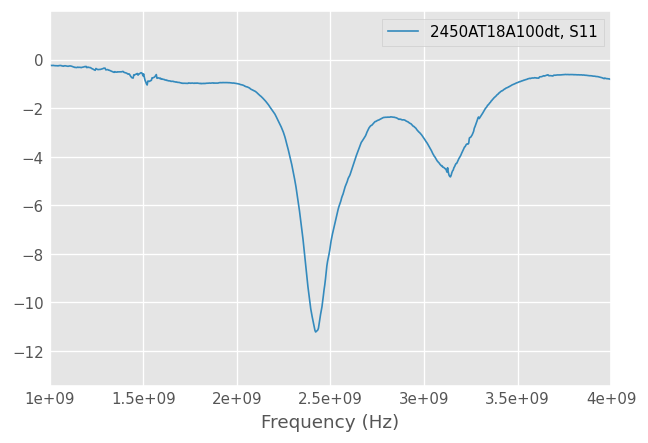

In [8]:
ant_detune.plot_s_db()

In [9]:
def tol_cap(x, t):
    match t:
        case 'A': return 0.05
        case 'B': return 0.1
        case 'C': return 0.25
        case 'D': return 0.5
        case 'F': return 0.01 * x
        case 'G': return 0.02 * x
        case 'J': return 0.05 * x
        case 'K': return 0.1 * x

def tol_inductor(x, t):
    match t:
        case 'C': return 0.2
        case 'S': return 0.3
        case 'J': return 0.05 * x
        case 'K': return 0.1 * x

def spec_to_array(tolfn, s):
    return np.array(list(map(lambda x: (float(x[0]), tolfn(float(x[0]), x[1])), map(lambda x: x.split(), s.split(',')))))

In [10]:
caps_tol = spec_to_array(tol_cap, '0.2 B, 0.3 B, 0.5 B, 0.7 B, 0.9 B, 1.0 B, 1.2 B, 1.5 B, 1.8 B, 2.0 B, 2.2 B, 2.4 B, 2.7 B, 3.0 B, 3.6 B, 4.3 B, 4.7 B, 5.6 C, 6.8 C, 7.5 C, 8.2 C, 9.1 C, 10 J, 12 J, 15 J, 22 J, 27 J, 30 J')
inductors_tol = spec_to_array(tol_inductor, '1.0 S, 1.2 S, 1.5 S, 1.8 S, 2.2 S, 2.4 S, 2.7 S, 3.0 S, 3.3 S, 3.9 S, 4.3 S, 4.7 S, 5.1 S, 5.6 S, 6.8 J, 7.5 J, 8.2 J, 10 J, 12 J, 15 J, 18 J, 22 J, 27 J, 33 J, 39 J, 47 J, 68 J, 100 J')

caps_tol = np.insert(caps_tol, 0, (0.001, 0.0), axis=0)
inductors_tol = np.insert(inductors_tol, 0, (0.001, 0.0), axis=0)

In [29]:
caps_tol

array([[1.00e-03, 0.00e+00],
       [2.00e-01, 1.00e-01],
       [3.00e-01, 1.00e-01],
       [5.00e-01, 1.00e-01],
       [7.00e-01, 1.00e-01],
       [9.00e-01, 1.00e-01],
       [1.00e+00, 1.00e-01],
       [1.20e+00, 1.00e-01],
       [1.50e+00, 1.00e-01],
       [1.80e+00, 1.00e-01],
       [2.00e+00, 1.00e-01],
       [2.20e+00, 1.00e-01],
       [2.40e+00, 1.00e-01],
       [2.70e+00, 1.00e-01],
       [3.00e+00, 1.00e-01],
       [3.60e+00, 1.00e-01],
       [4.30e+00, 1.00e-01],
       [4.70e+00, 1.00e-01],
       [5.60e+00, 2.50e-01],
       [6.80e+00, 2.50e-01],
       [7.50e+00, 2.50e-01],
       [8.20e+00, 2.50e-01],
       [9.10e+00, 2.50e-01],
       [1.00e+01, 5.00e-01],
       [1.20e+01, 6.00e-01],
       [1.50e+01, 7.50e-01],
       [2.20e+01, 1.10e+00],
       [2.70e+01, 1.35e+00],
       [3.00e+01, 1.50e+00]])

In [12]:
# initial guess values
L0 = 10 # nH
C0 = 1 # pF
x0 = (L0, C0)
opt_frequency = '2.4-2.4835GHz'
# bounds
L_minmax = (0.001, np.max(inductors_tol[:,0])) #nH
C_minmax = (0.001, np.max(caps_tol[:,0])) # pF

def make_objective(fun, frequency=None):
    def objective(x):
        ntw = fun(*x)
        if frequency:
            ntw = ntw[frequency]
        return np.sum(ntw.s_mag**2)
    return objective

In [13]:
from scipy.optimize import minimize
from joblib import Parallel, delayed
from functools import partial

def optimize_best(funs, *args, frequency=None, **kwargs):
    best = None
    best_net = None
    for fun in funs:
        res = minimize(make_objective(fun, frequency=frequency), *args, **kwargs)
        if best is None or res.fun < best.fun:
            best = res
            best_net = fun
    return best_net(*best.x)

def optimize(fun, *args, frequency=None, **kwargs):
    res = minimize(make_objective(fun, frequency=frequency), *args, method='SLSQP', **kwargs)
    return (fun, *res.x)

def optimize_all(funs, *args, **kwargs):
    return Parallel(n_jobs=-1)(delayed(optimize)(fun, *args, **kwargs) for fun in funs)
    #return rf.NetworkSet(result)

In [14]:
def matching_network_LsCp(ant, L, C):
    ' L and C in nH and pF'
    ntw = line.inductor(L*1e-9)**line.shunt_capacitor(C*1e-12)**ant
    ntw.name = f'L{L}nH - Cshunt{C}pF'
    return ntw

def matching_network_CsLp(ant, L, C):
    ' L and C in nH and pF'
    ntw = line.capacitor(C*1e-12)**line.shunt_inductor(L*1e-9)**ant
    ntw.name = f'C{C}pF - Lshunt{L}nH'
    return ntw

def matching_network_LpCs(ant, L, C):
    ' L and C in nH and pF'
    ntw = line.shunt_inductor(L*1e-9)**line.capacitor(C*1e-12)**ant
    ntw.name = f'Lshunt{L}nH - C{C}pF'
    return ntw

def matching_network_CpLs(ant, L, C):
    ' L and C in nH and pF'
    ntw = line.shunt_capacitor(C*1e-12)**line.inductor(L*1e-9)**ant
    ntw.name = f'Cshunt{C}pF - L{L}nH'
    return ntw

matching_network_funs = list(partial(f, ant_detune) for f in (matching_network_LsCp, matching_network_CsLp, matching_network_LpCs, matching_network_CpLs))

In [15]:
%time

minima = optimize_all(matching_network_funs, x0, bounds=(L_minmax, C_minmax), frequency=opt_frequency)
minima
#ntws.plot_s_vswr()

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 22.9 µs


[(functools.partial(<function matching_network_LsCp at 0x168d172e0>, 1-Port Network: '2450AT18A100dt',  1000000000.0-4000000000.0 Hz, 801 pts, z0=[50.+0.j]),
  1.218796133942418,
  0.001),
 (functools.partial(<function matching_network_CsLp at 0x168d17b00>, 1-Port Network: '2450AT18A100dt',  1000000000.0-4000000000.0 Hz, 801 pts, z0=[50.+0.j]),
  4.6123315874184065,
  30.0),
 (functools.partial(<function matching_network_LpCs at 0x168d17a60>, 1-Port Network: '2450AT18A100dt',  1000000000.0-4000000000.0 Hz, 801 pts, z0=[50.+0.j]),
  4.4390587049115755,
  12.215724725912326),
 (functools.partial(<function matching_network_CpLs at 0x168d17920>, 1-Port Network: '2450AT18A100dt',  1000000000.0-4000000000.0 Hz, 801 pts, z0=[50.+0.j]),
  2.773124643271481,
  0.9582439689935499)]

In [16]:
import itertools

def brute_force(funs, metric, values):
    results = []
    for config in itertools.product(*values):
        for fun in funs:
            ntw = fun(*config)
            score = np.sum(ntw.s_mag**2)
            results.append((score, fun, config))
    return sorted(results, key=lambda x: x[0])

In [17]:
def find_tol(x, tols):
    #sel = np.nonzero(tols[:,0] == x[:,np.newaxis])
    #return tols[sel[1],1]
    for y in tols:
        if x == y[0]:
            return y[1]

find_tol(2.7, caps_tol)

0.1

In [18]:
def closest_values(value, components):
    rel = components[:,0] / value - 1.0
    signs = np.sign(rel)
    best = np.argsort(np.abs(rel))
    result = [components[best[0]]]
    if np.abs(rel[best[0]]) > 1e-3:
        for i in range(1, len(rel)):
            result.append(components[best[i]])
            if signs[best[i]] != signs[best[0]]:
                break    
    return result

def expand_tolerance(l, c):
    ls = [l[0]]
    cs = [c[0]]
    if l[1] > 0.0:
        ls.append(l[0]-l[1])
        ls.append(l[0]+l[1])
    if c[1] > 0.0:
        cs.append(c[0]-c[1])
        cs.append(c[0]+c[1])
    return list(itertools.product(ls, cs))

def component_combinations(minima, l_values, c_values):
    for f, l, c in minima:
        l_components = closest_values(l, l_values)
        c_components = closest_values(c, c_values)
        for lt, ct in itertools.product(l_components, c_components):
            for l, c, in expand_tolerance(lt, ct):
                yield (f, lt[0], ct[0]), (l, c)

##################################

from unittest import TestCase, TextTestRunner, defaultTestLoader
class TestComponentCombinations(TestCase):
    def test_closest_values_exact(self):
        result = closest_values(1.001, np.array(((0.9, 0.1), (1.0, 0.1), (1.1, 0.1))))
        self.assertIsNone(np.testing.assert_array_equal(result, [(1.0, 0.1)]))
        
    def test_closest_values(self):
        result = closest_values(0.95, np.array(((0.9, 0.1), (1.0, 0.1), (1.1, 0.1))))
        self.assertIsNone(np.testing.assert_array_equal(result, [(0.9, 0.1), (1.0, 0.1)]))

    def test_closest_values_one_sided(self):
        result = closest_values(1.0, np.array(((0.4, 0.1), (0.9, 0.1), (0.8, 0.1), (1.5, 0.1), (1.6, 0.2))))
        self.assertIsNone(np.testing.assert_array_equal(result, [(0.9, 0.1), (0.8, 0.1), (1.5, 0.1)]))

    def test_expand_tolerance(self):
        result = expand_tolerance((2.7, 0.2), (1.0, 0.1))
        print(result)
        self.assertIsNone(np.testing.assert_allclose(
            result,
             [(2.7, 1.0), (2.7, 0.9), (2.7, 1.1),
              (2.5, 1.0), (2.5, 0.9), (2.5, 1.1),
              (2.9, 1.0), (2.9, 0.9), (2.9, 1.1)]))

TextTestRunner().run(defaultTestLoader.loadTestsFromTestCase(TestComponentCombinations))

....
----------------------------------------------------------------------
Ran 4 tests in 0.012s

OK


[(2.7, 1.0), (2.7, 0.9), (2.7, 1.1), (2.5, 1.0), (2.5, 0.9), (2.5, 1.1), (2.9000000000000004, 1.0), (2.9000000000000004, 0.9), (2.9000000000000004, 1.1)]


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

In [19]:
combinations = list(component_combinations(minima, inductors_tol, caps_tol))
#combinations = list(combinations)[0:3]
#combinations

In [20]:
def compute_combinations(combinations):
    combinations = list(combinations)
    all_results = Parallel(n_jobs=-1)(delayed(tag[0])(*lc) for tag, lc in combinations)
    tagged = ((tag, ntw) for ((tag, args), ntw) in zip(combinations, all_results))
    #print(list(tagged))
    grouped = []
    for fun, per_fun in itertools.groupby(tagged, lambda x: x[0][0]):
        fun_groups = []
        for _, ntws in itertools.groupby(per_fun, lambda x: x[0]):
            fun_groups.append(rf.NetworkSet(list(ntw for _, ntw in ntws)))
        grouped.append(fun_groups)
    return grouped

In [21]:
ntws_by_fun = compute_combinations(combinations)

In [22]:
def plot_ntws_tolerance(ntws, func='s_vswr'):
    getattr(ntws[0], f'plot_{func}')()
    ax = gca()
    ax.fill_between(ntws[0].frequency.f,
                    getattr(ntws, f'min_{func}').s_re[:,0,0],
                    getattr(ntws, f'max_{func}').s_re[:,0,0],
                    alpha=0.3, color=ax.get_lines()[-1].get_color())
    plt.xticks(rotation=45)

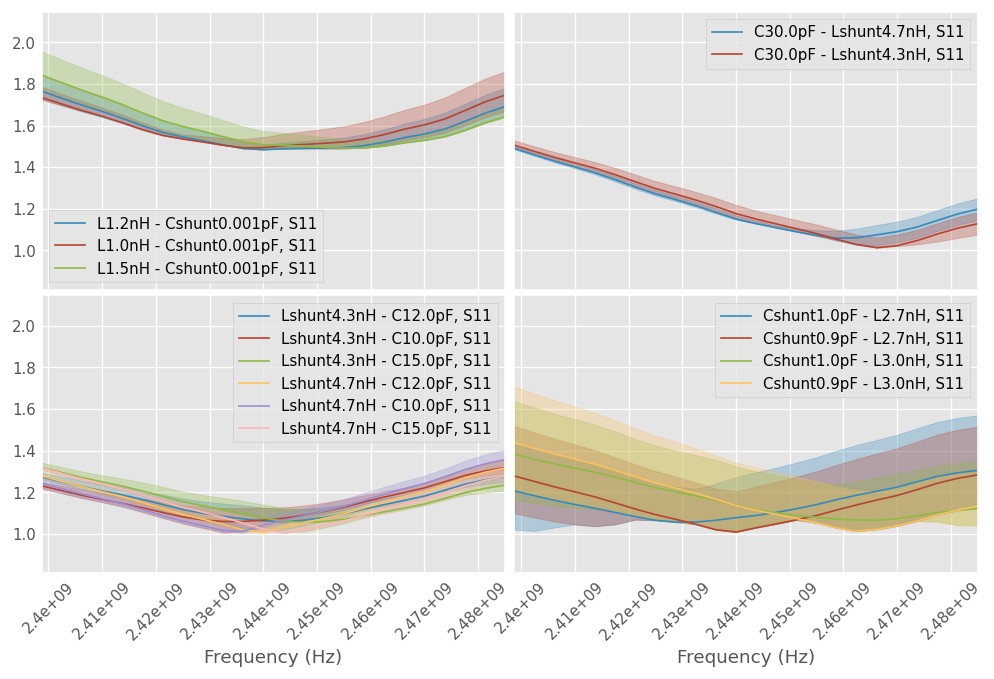

In [23]:
subplots(2, 2, figsize=(10, 6), sharex=True, sharey=True, gridspec_kw={'wspace': 0.02, 'hspace': 0.02})
for i, configs in enumerate(ntws_by_fun):
    ax = subplot(2, 2, i+1)
    plt.xticks(rotation=45)
    #fig = figure(i+1)
    if i < 2:
        ax.set_xlabel(None)
    for ntws in configs:
        plot_ntws_tolerance(ntws[opt_frequency])

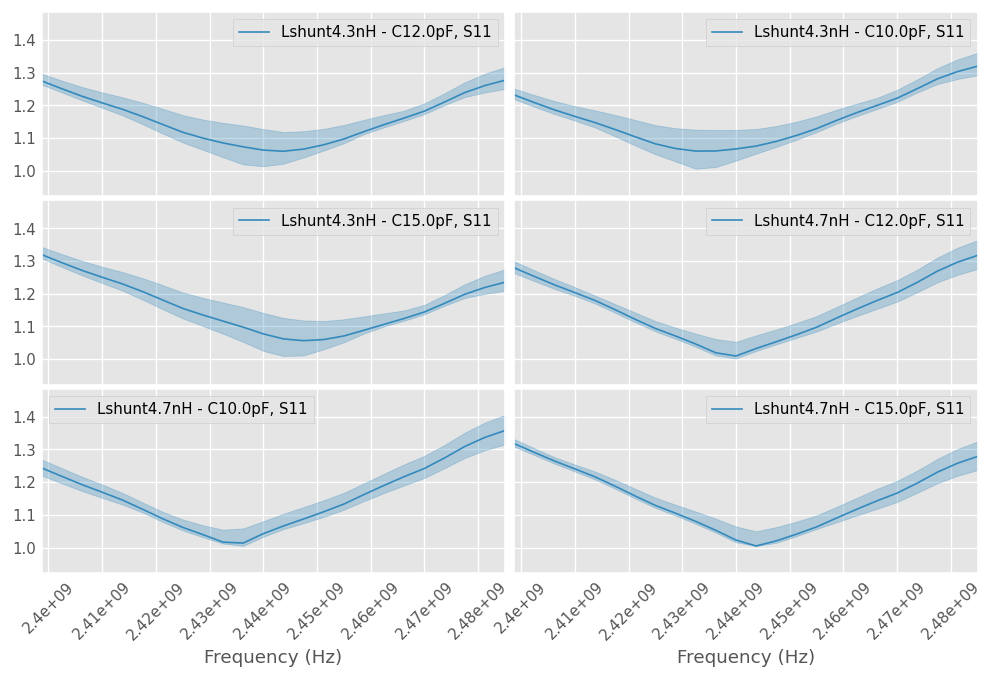

In [24]:
def plot_configs_in_subplots(configs, frequency=None):
    nrow = (len(configs) + 2) // 3
    subplots(3, nrow, figsize=(10, nrow * 3), sharex=True, sharey=True, gridspec_kw={'wspace': 0.02, 'hspace': 0.02})
    for i, cmp in enumerate(ntws_by_fun[2]):
        subplot(3, nrow, i+1)
        if frequency:
            cmp = cmp[frequency]
        plot_ntws_tolerance(cmp)

plot_configs_in_subplots(ntws_by_fun[2], frequency=opt_frequency)

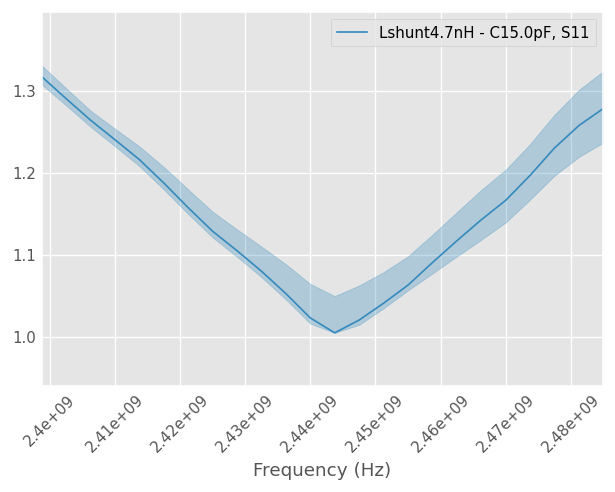

In [25]:
def get_best_config(configs, frequency=None):
    best = None
    score = np.inf
    for config in configs:
        #print(config.max_s_mag.s_mag)
        if frequency:
            cscore = np.sum(config[frequency].max_s_mag.s_mag ** 2)
        else:
            cscore = np.sum(config.max_s_mag.s_mag ** 2)
        if cscore < score:
            score = cscore
            best = config
    return best

best = get_best_config([x for y in ntws_by_fun for x in y], frequency=opt_frequency)
plot_ntws_tolerance(best[opt_frequency])

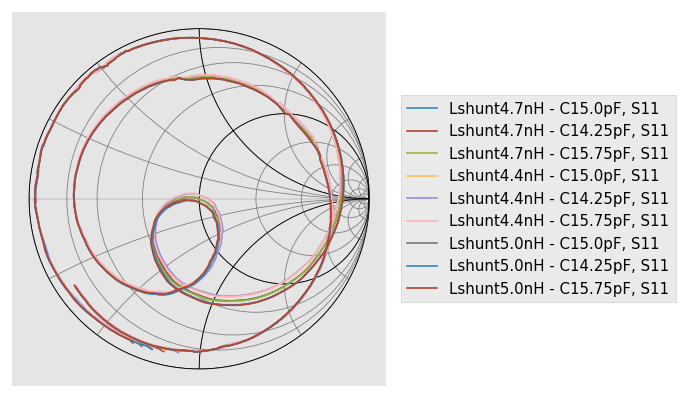

In [26]:
best.plot_s_smith()
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)

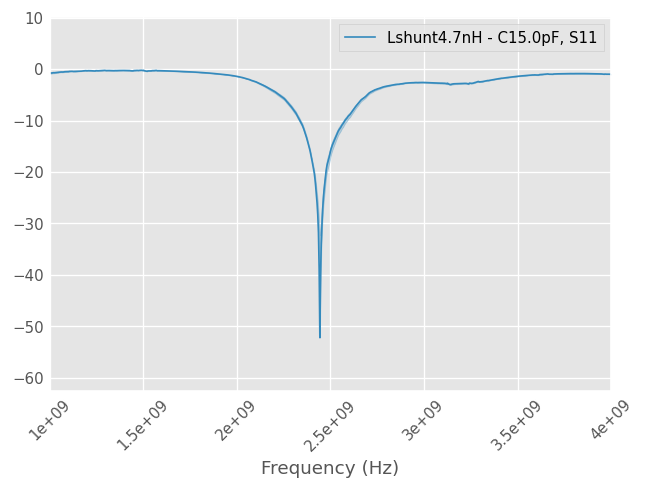

In [27]:
plot_ntws_tolerance(best, func='s_db')